# Introduction

## Problem description: A/B testing

---

## Setup

Players (users) are randomly split in two groups:

- group1 - even loginIDs
- group2 - odd loginIDs

We are testing which is the best time / place to show popup to players asking them to allow push notifications:

- group1 - immediately after the installation (before the first tutorial battle)
- group2 - after the tutorial (which consists of 5 battles)

We are optimizing towards:

- Hit rate (% of players who allow push notifications)
- Player Retention

Test was run for two weeks (14 days). Only players that participated in the test appear in the provided data.

## Data

There are two anonimized files:

- `notification_allowed.csv`
- `user_history.csv`

### notification_allowed.csv
Sent after request popup has been shown and player has answered (closing the app defaults to `false` as an answer).

```
login_id = int, starting from 1
time
allowed_notifications = true / false
date_id = int, starting from 0, measuring days since the start of the test
```

### user_history.csv
Generated at the end of each day. It is sent for every active user and for every payer (all time payer). When 21 days pass after the player has logged in for the last time, player no longer appears in this table. This is not true for payers, as they are eligible to appear in this table no matter how long has passed since the last log in.

```
  login_id = int, starting from 1
  registration_date_id = date_id when a player has joined the game
  registration_channel = Paid/Organic
  registration_country = country of origin of the first session
  payer = player has spent money at any time in the past
  dau = daily active player: 0 or 1 in this table
  sessions_count = daily count of sessions
  playtime = daily total playtime
  last_login_day = date_id of the last login, up to this day
  days_active_last_7_days = number of days user was active, including this day
  cohort_size = 1 for all in this table
  elo_rating = elo (trophie count) at the end of the day
  arena_level = arena level at the end of the day
  gold = gold stash at the end of the day
  runes_stash_class1_tier1 = stash of various currencies
  runes_stash_class2_tier1
  runes_stash_class3_tier1
  runes_stash_tier2
  spell_runes_stash
  hero_dust
  item_dust
  gold_gained_total = stats for various currencies
  gold_bought_total
  gold_spent_total
  runes_gained_total_class1_tier1
  runes_gained_total_class2_tier1
  runes_gained_total_class3_tier1
  runes_gained_total_tier_2
  spell_runes_gained_total
  runes_spent_class1_tier1
  runes_spent_class2_tier1
  runes_spent_class3_tier1
  runes_spent_total_tier2
  spell_runes_spent_total
  hero_dust_spent_total
  hero_dust_gained_total
  tokens
  tokens_gained_total
  enter_queue_count = number of times player has entered PvP queue
  battles_played = daily battles played
  battles_won = daily battles won
  battles_played_total = battles played up to this day
  battles_won_total = battles won up to this day
  heroes_unlocked = heroes unlocked up to this day
  heroes_level = hero stats
  hero_shards = hero stats
  minion_upgrades = number of times user has upgraded minions
  free_chests_opened_total = various chest stats
  silver_chests_opened_total
  golden_chests_opened_total
  magical_chests_opened_total
  victory_chests_opened_total
  pvp_event_small_chest_small
  pvp_event_small_chest_medium
  pvp_event_small_chest_large
  pvp_event_big_chest_small
  pvp_event_big_chest_medium
  pvp_event_big_chest_large
  cards_gained_total = various card stats
  minion_cards_gained_common_total
  minion_cards_gained_rare_total
  minion_cards_gained_epic_total
  minion_cards_gained_legendary_total
  spell_cards_gained_common_total
  spell_cards_gained_rare_total
  spell_cards_gained_epic_total
  spell_cards_gained_legendary_total
  campaign_tickets = various campaign stats
  max_campaign_level
  equipment_bonus
  campaign_battles
  campaign_battles_total
  event_battles = various live event stats
  event_battles_total
  event_tokens
  group_points
  lives_spent
  milestone_points
  date_id = int, starting from 0, measuring days since the start of the test
```


## Import libraries

In [25]:
# Basic libraries
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
from sklearn.tree import plot_tree

import random
from pathlib import Path

import scipy.stats as stats
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest


## Util functions

In [26]:
def na_percentage(df):
  missing_percentage = df.isna().sum() / df.shape[0] * 100
  missing_percentage_sorted = missing_percentage.sort_values(ascending=False)
  print(missing_percentage_sorted)

## Load data

In [27]:
file_path_notification = "/Users/mipopovic/Desktop/A_B_testing/data/notification_allowed.csv"
df_not = pd.read_csv(file_path_notification)
df_not.shape

(3859, 4)

In [28]:
df_not.head()

,login_id,time,allowed_notifications,date_id
0,352,999,True,0
1,184,2780,True,0
2,162,2928,False,0
3,130,3689,True,0
4,124,4547,True,0


In [29]:
file_path_user_history = "/Users/mipopovic/Desktop/A_B_testing/data/user_history.csv"
df_us = pd.read_csv(file_path_user_history)
df_us.shape

(122459, 79)

In [30]:
df_us.head()

,login_id,registration_date_id,registration_channel,registration_country,payer,dau,sessions_count,playtime,last_login_day,days_active_last_7_days,...,equipment_bonus,campaign_battles,campaign_battles_total,event_battles,event_battles_total,event_tokens,group_points,lives_spent,milestone_points,date_id
0,1,0,Organic,Canada,False,1,3,1351,0,1,...,0.0,5,5,0,0,15,0,0,0,0
1,2,0,Organic,Brazil,False,1,1,1046,0,1,...,0.0,2,2,0,0,15,0,0,0,0
2,3,0,Organic,Brazil,False,1,7,5854,0,1,...,0.0,8,8,0,0,40,0,0,0,0
3,4,0,Paid,France,False,1,1,772,0,1,...,0.0,1,1,0,0,40,0,0,0,0
4,5,0,Paid,United Kingdom,False,1,1,521,0,1,...,0.0,2,2,0,0,5,0,0,0,0


# EDA

## Checking for missing values

In [31]:
na_percentage(df_not)

login_id                 0.0
time                     0.0
allowed_notifications    0.0
date_id                  0.0
dtype: float64


In [32]:
na_percentage(df_us)

date_id                     0.0
login_id                    0.0
registration_date_id        0.0
registration_channel        0.0
registration_country        0.0
                           ... 
cohort_size                 0.0
elo_rating                  0.0
arena_level                 0.0
gold                        0.0
runes_stash_class1_tier1    0.0
Length: 79, dtype: float64


## Checking for duplicates 

In [72]:
df_us.duplicated(subset=['login_id', 'date_id']).sum()

0

# Hit Rate Analysis

Splitting the users into:
- Group 1 (evend ID): popup shown immediately
- Gruop 2 (odd ID): popup shown after tutorial

In [33]:
df_not['group'] = df_not['login_id'].apply(lambda x: 1 if x % 2 == 0 else 2)

Count the total responses and hits for each group, which we use to calculate the hit rate

In [34]:
hit_rate_summary = df_not.groupby('group')['allowed_notifications'].agg(
    total_responses='count',
    hits='sum'
).reset_index()

hit_rate_summary['hit_rate'] = hit_rate_summary['hits'] / hit_rate_summary['total_responses']

In [35]:
hit_rate_summary.head()

,group,total_responses,hits,hit_rate
0,1,2487,1434,0.576598
1,2,1372,861,0.627551


- On the bar plot below we can observe a significant difference in hit rate between the two groups
- A stastical test is warranted to corrobarate this observation

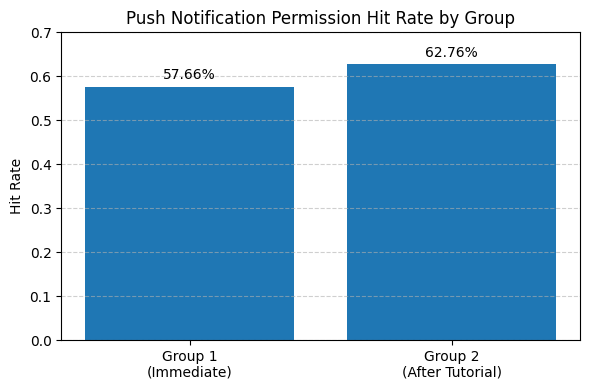

In [36]:
plt.figure(figsize=(6, 4))
bars = plt.bar(hit_rate_summary['group'], hit_rate_summary['hit_rate'])

for bar, rate in zip(bars, hit_rate_summary['hit_rate']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{rate:.2%}', ha='center', va='bottom')

plt.xticks([1, 2], ['Group 1\n(Immediate)', 'Group 2\n(After Tutorial)'])
plt.ylabel('Hit Rate')
plt.title('Push Notification Permission Hit Rate by Group')
plt.ylim(0, 0.7)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Statistical Tests

### Two-Proportion Z-Test

A **two-proportion z-test** evaluates whether the **difference between two independent proportions** is statistically significant, within a specified confidence level.

The test is appropriate when the following assumptions are met:
- The groups are **independent** (no overlap in observations)
- The data is **randomly and independently sampled** 
- The **sample sizes are large enough** for normal approximation to apply:
- The population size is at least **10 times larger than the sample** (to justify independence)

All conditions are satisfied in this test, so a **two-proportion z-test is appropriate.** 

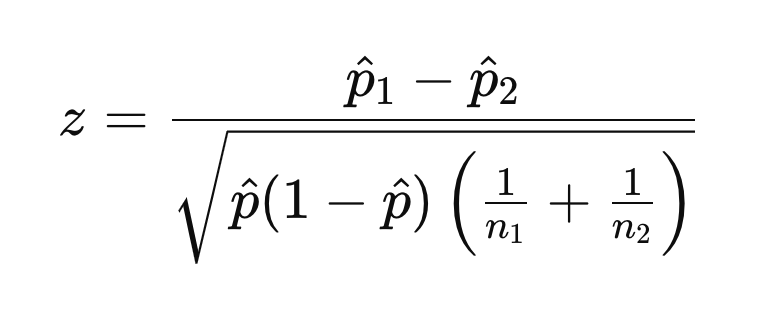

- **Null hypothesis (H0)**: there is **no difference** in hit rate between Group 1 and Group 2
    - H0: p1 = p2

- **Alternate hypothesis (H1)**: there **is a difference** in hit rate between Group 1 and Group 2.
    - H1: p1 != p2
 
- If the resulting p-value is less than 0.05 (5%), the null hypothethis will be rejected

In [125]:
counts = hit_rate_summary['hits'].values
nobs = hit_rate_summary['total_responses'].values
stat, pval = proportions_ztest(count=counts, nobs=nobs)
print(f"Z-test statistic = {stat:.4f}, p-value = {pval:.4f} ({pval * 100:.1f}%)")

Z-test statistic = -3.0861, p-value = 0.0020 (0.2%)


In [126]:
print(counts)
print(nobs)

[1434  861]
[2487 1372]


In [123]:
hit_rate_summary.head()

,group,total_responses,hits,hit_rate
0,1,2487,1434,0.576598
1,2,1372,861,0.627551


- The p-value is 0.2%, meaning there is a **0.2% probability** of observing a difference in hit rates as extreme as this—or more—**if there were actually no real difference** between the groups (i.e., if the null hypothesis were true).

- Since the p-value is **less than 0.05**, we **reject the null hypothesis** at the 5% significance level. This provides strong evidence that the **hit rates differ significantly** between the two groups.

- **Group 2**, which received the popup **after the tutorial**, had a **higher hit rate**. This suggests that delaying the notification request until after the tutorial is **statistically more effective**.





### Confidence Interval for Difference in Proportions

### Chi-Squared Test for Independence


In [38]:
from scipy.stats import chi2_contingency

# Contingency table
# Rows = group, Columns = [allowed, not allowed]
table = [
    [1434, 2487 - 1434],
    [861, 1372 - 861]
]

chi2, p, dof, expected = chi2_contingency(table)

## Conclusion

# Retention Rate Analysis

- The goal of this analysis is to see which group of users has the higher retention rate
- To achieve that we need to:
    - See the daily activity of the users are since their registration
    - Average out, plot and visually asses those differences
    - Perform statistical tests to confirm/deny visual assesment

Splitting the users into:
- Group 1 (evend ID): popup shown immediately
- Gruop 2 (odd ID): popup shown after tutorial

In [ ]:
df_us['group'] = df_us['login_id'].apply(lambda x: 1 if x % 2 == 0 else 2)

Calculate days since registration

In [97]:
df_us['days_since_registration'] = df_us['date_id'] - df_us['registration_date_id']

- Here we **pivot the table** so that each row is one user (login_id)
    - **Columns** become the days since the user registered (Day 0, Day 1, …)
    - **Values** are daily activity (dau = 1 or 0)
    - **fillna(0)** replaces missing values (no record = inactive that day)

In [98]:
retention_df = df_us.pivot_table(index='login_id', 
                                 columns='days_since_registration', 
                                 values='dau').fillna(0)

In [99]:
retention_df.head()

days_since_registration,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
login_id,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We add the group information to the retention_df

In [100]:
retention_df = retention_df.join(
    df_us[['login_id', 'group']].drop_duplicates().set_index('login_id')
)

In [101]:
retention_df.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,group
login_id,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


We average out the values for each group

In [102]:
retention_by_group = retention_df.groupby('group').mean()


In [103]:
retention_by_group.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
group,,,,,,,,,,,,,,,,,,,,,
1,0.999196,0.425070,0.358779,0.319004,0.288871,0.270791,0.252310,0.239454,0.229008,0.218160,...,0.098835,0.087585,0.075934,0.064283,0.056649,0.045802,0.036963,0.028526,0.018481,0.008839
2,0.998795,0.458635,0.384337,0.342972,0.312851,0.290361,0.270281,0.251406,0.241365,0.229719,...,0.100000,0.086747,0.075502,0.064659,0.056225,0.045382,0.035743,0.028112,0.018474,0.008835


- On the plot below we can observe the retention curves for Group 1 and Group 2
- There seems to be little-to-no difference for the rentention rates
- A more detailed statistical assesment is warranted 

Text(0, 0.5, 'Retention Rate')

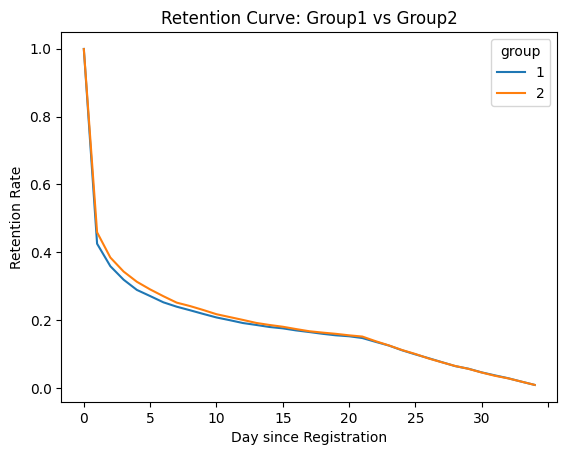

In [57]:
retention_by_group.T.plot(title='Retention Curve: Group 1 vs Group 2')
plt.xlabel('Day since Registration')
plt.ylabel('Retention Rate')


### Statistical Tests

#### Two-Proportion Z-Test

To determine whether there is a statistically significant difference in retention rates between **Group 1** and **Group 2**, we perform a **Two-Proportion Z-Test.**

Although we analyze retention across multiple days, this is a similar problem to **hit rate comparison**, because each individual day can be treated as a separate comparison of **binary outcomes** *(retained vs. not retained)*. This aligns with a classic **two-proportion comparison**: we are evaluating whether the **proportion of users who return** on a given day differs between **two independent groups**.

The test is appropriate because:
- The samples (**Group 1** and **Group 2**) are **independent** (randomly assigned).
- The outcome (**user retention on a given day**) is **binary**.
- The **sample sizes** are large enough for the **normal approximation** used in the Z-test to be valid.

In [156]:
def ztest_day(day):
    day_data = retention_df[day] # Binary retention data (1 if active, 0 if not) for a given day
    # Split data by experimental group
    group1 = day_data[retention_df['group'] == 1]
    group2 = day_data[retention_df['group'] == 2]
    count = [group1.sum(), group2.sum()] #number of active users that day
    nobs = [group1.count(), group2.count()] #number of people in that group
    stat, pval = proportions_ztest(count=count, nobs=nobs) 
    return stat, pval

Calculating the Z statistic and p-value for each of the 35 days

In [164]:
ztest_results = []
for day in range(35):
    stat, pval = ztest_day(day)
    ztest_results.append({'day': day, 'z_stat': stat, 'p_value': pval})
results_df = pd.DataFrame(ztest_results)

In [174]:
results_df

,day,z_stat,p_value
0,0,0.446989,0.654883
1,1,-2.384538,0.017101
2,2,-1.866095,0.062028
3,3,-1.797024,0.072332
4,4,-1.844723,0.065078
5,5,-1.536782,0.124347
6,6,-1.443145,0.148980
7,7,-0.979870,0.327150
8,8,-1.028013,0.303944
9,9,-0.978242,0.327955


- Based on the graph below we can observe there is **no statistically significant difference** for the retention rates between Group 1 and Group 2

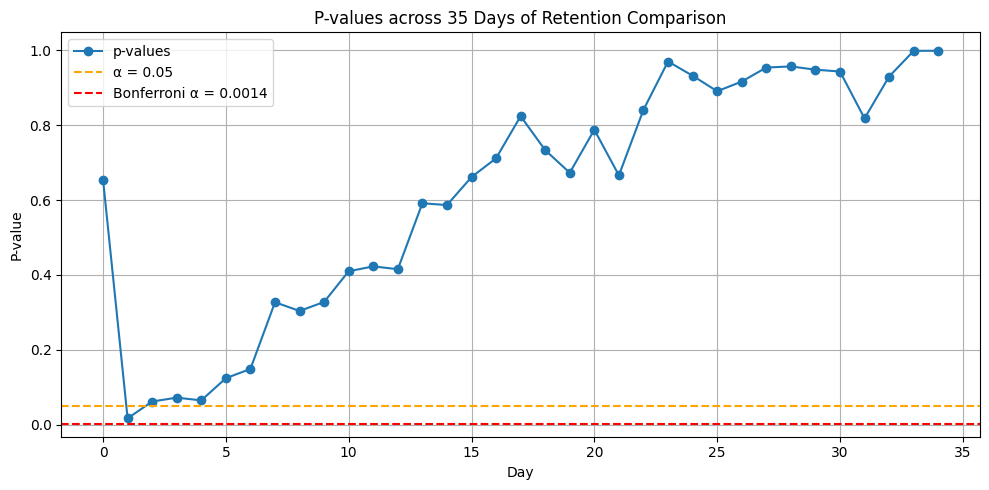

In [175]:
alpha = 0.05
bonferroni_threshold = alpha / len(results_df)

plt.figure(figsize=(10, 5))
plt.plot(results_df['day'], results_df['p_value'], marker='o', label='p-values')
plt.axhline(y=alpha, color='orange', linestyle='--', label='α = 0.05')
plt.axhline(y=bonferroni_threshold, color='red', linestyle='--', label=f'Bonferroni α = {bonferroni_threshold:.4f}')
plt.title('P-values across 35 Days of Retention Comparison')
plt.xlabel('Day')
plt.ylabel('P-value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The exception is day 1 where the p-value is 0.017 (1.7%), but this can be explained as an anomally, since the test was ran 35 times.

In [172]:
results_df[results_df['p_value'] < 0.05]

,day,z_stat,p_value
1,1,-2.384538,0.017101


#### Chi-Squared Test for Independence


In [151]:

# Chi-squared tests
chi_results = []
for day in retention_days:
    sub = retention_df[retention_df['day'] == day]
    retained = sub['retained'].values
    total = sub['total'].values
    contingency = [
        [retained[0], total[0] - retained[0]],
        [retained[1], total[1] - retained[1]]
    ]
    chi2, p, _, _ = chi2_contingency(contingency)
    chi_results.append({'day': day, 'chi2_stat': chi2, 'p_value': p})

chi_df = pd.DataFrame(chi_results)
retention_df = retention_df.merge(chi_df, on='day')
print(retention_df)

KeyError: 'day'

#### Check confounders

In [46]:
# Get only one row per user for confounders
df_users = df_us.sort_values("date_id").drop_duplicates("login_id")

# Compare registration_channel
channel_ct = pd.crosstab(df_users['group'], df_users['registration_channel'])
chi2_channel, p_channel, _, _ = chi2_contingency(channel_ct)

# Compare registration_country (use top 10 countries for readability)
top_countries = df_users['registration_country'].value_counts().head(10).index
country_ct = pd.crosstab(
    df_users[df_users['registration_country'].isin(top_countries)]['group'],
    df_users[df_users['registration_country'].isin(top_countries)]['registration_country']
)
chi2_country, p_country, _, _ = chi2_contingency(country_ct)

# Compare payer status
payer_ct = pd.crosstab(df_users['group'], df_users['payer'])
chi2_payer, p_payer, _, _ = chi2_contingency(payer_ct)

print(f"Channel p-value: {p_channel:.4f}")
print(f"Country p-value: {p_country:.4f}")
print(f"Payer p-value: {p_payer:.4f}")

Channel p-value: 0.9659
Country p-value: 0.2520
Payer p-value: 0.9988


## Time Series DAU and Retention Curves

# Summation and Final Conclusion

- **Group 2**, which received the popup **after the tutorial**, had a **higher hit rate**. This suggests that delaying the notification request until after the tutorial is **statistically more effective**.

- There is **no statistical significance** between Group 1 and Group 2 for retention rates 
